[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dpholmes/DirectStiffnessMethod/blob/master/planarBeams.ipynb)

<h1>Direct Stiffness Method: Frame Elements</h1>
<h3>Structural Mechanics, Boston University</h3>
<h4>Core Functionality Provided by Prof. Douglas P. Holmes</h4>
<h4>Additional Functionality Added by Daniel W. Bradford</h4>

In [1]:
# Here are some common libraries that expand the functionality of python
import math         # sine, cosine, sqrt, etc.
import numpy as np  # so we can work with matrices

import matplotlib
import matplotlib.pyplot as plt # plotting

import sympy as sp        # symbolic calculations

In [2]:
# uncomment the lines below if using Google Colab

#from IPython.display import Math, HTML

#def load_mathjax_in_cell_output():
#  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
#               "mathjax/latest/MathJax.js?config=default'></script>"))
#get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

#sp.init_printing() 

<h2>Deriving the Elemental Stiffness Matrix for Beam Elements</h2>

In [3]:
x, a1, a2, a3, a4, L = sp.symbols('x a1 a2 a3 a4 L') # deflection w(x) = a1+a2*x+a3*x^2+a4*x^3
w1, w2, theta_1, theta_2 = sp.symbols('w1 w2 theta_1 theta_2') # degrees of freedom (DoF)
E, I = sp.symbols('E I') # materials and geometry
F1, M1, F2, M2 = sp.symbols('F1 M1 F2 M2') # forces (y direction) and couples
P, q = sp.symbols('P q') # force, force/length

In [4]:
def w(x):
    return a1+a2*x+a3*x**2+a4*x**3

In [5]:
w(x)

a1 + a2*x + a3*x**2 + a4*x**3

In [6]:
# note: I've defined the RHS as negative because of how SymPy solves equations. 
# You get the correct answer either way, but the L-matrix has negative signs in opposite places
bc = [
    sp.Eq(w1,-w(0)), 
    sp.Eq(theta_1,-sp.diff(w(x),x).subs(x,0)),
    sp.Eq(w2,-w(L)),
    sp.Eq(theta_2,-sp.diff(w(x),x).subs(x,L))
]

In [7]:
bc[2]

Eq(w2, -L**3*a4 - L**2*a3 - L*a2 - a1)

In [8]:
coeffs = [a1,a2,a3,a4]

In [9]:
Lmat, DoF = sp.linear_eq_to_matrix(bc,coeffs)

In [10]:
Lmat

Matrix([
[1, 0,    0,      0],
[0, 1,    0,      0],
[1, L, L**2,   L**3],
[0, 1,  2*L, 3*L**2]])

In [11]:
Lmat.inv()

Matrix([
[      1,       0,       0,       0],
[      0,       1,       0,       0],
[-3/L**2,    -2/L,  3/L**2,    -1/L],
[ 2/L**3, L**(-2), -2/L**3, L**(-2)]])

In [12]:
# Here again, the negative sign is to be consistent with the negative sign above in bc = [...]
a = Lmat.inv()*(-DoF)

In [13]:
a1, a2, a3, a4 = a[0], a[1], a[2], a[3]

In [14]:
w(x)

theta_1*x + w1 + x**3*(theta_1/L**2 + theta_2/L**2 + 2*w1/L**3 - 2*w2/L**3) + x**2*(-2*theta_1/L - theta_2/L - 3*w1/L**2 + 3*w2/L**2)

In [15]:
forcesCouples = [
    sp.Eq(F1,  E*I*sp.diff(w(x),x,3).subs(x,0)),
    sp.Eq(M1, -E*I*sp.diff(w(x),x,2).subs(x,0)),
    sp.Eq(F2, -E*I*sp.diff(w(x),x,3).subs(x,L)),
    sp.Eq(M2,  E*I*sp.diff(w(x),x,2).subs(x,L))
]

In [16]:
forcesCouples[0]

Eq(F1, 6*E*I*(theta_1 + theta_2 + 2*w1/L - 2*w2/L)/L**2)

In [17]:
DoF = [w1, theta_1, w2, theta_2]
Kel_b, FM = sp.linear_eq_to_matrix(forcesCouples,DoF)

In [18]:
-FM

Matrix([
[F1],
[M1],
[F2],
[M2]])

In [19]:
Kel_b = -Kel_b

In [20]:
DoF

[w1, theta_1, w2, theta_2]

In [21]:
Kel_b

Matrix([
[ 12*E*I/L**3,  6*E*I/L**2, -12*E*I/L**3,  6*E*I/L**2],
[  6*E*I/L**2,     4*E*I/L,  -6*E*I/L**2,     2*E*I/L],
[-12*E*I/L**3, -6*E*I/L**2,  12*E*I/L**3, -6*E*I/L**2],
[  6*E*I/L**2,     2*E*I/L,  -6*E*I/L**2,     4*E*I/L]])

<h2>Elemental Stiffness Matrix for Truss Elements</h2>


In [22]:
E, A, L = sp.symbols('E A L') # materials and geometry

In [23]:
Kel_t = E*A/L*sp.Array([
    [1, 0, -1, 0],
    [0, 0, 0, 0],
    [-1, 0, 1, 0],
    [0, 0, 0, 0]
])

In [24]:
Kel_t

[[A*E/L, 0, -A*E/L, 0], [0, 0, 0, 0], [-A*E/L, 0, A*E/L, 0], [0, 0, 0, 0]]

<h2>Elemental Stiffness Matrix for Frame Elements</h2>

In [25]:
Kel_f = sp.Array([
    [Kel_t[0][0], 0, 0, Kel_t[0][2], 0, 0],
    [0, Kel_b[0, 0], Kel_b[0, 1], 0, Kel_b[0, 2], Kel_b[0, 3]],
    [0, Kel_b[1, 0], Kel_b[1, 1], 0, Kel_b[1, 2], Kel_b[1, 3]],
    [Kel_t[2][0], 0, 0, Kel_t[2][2], 0, 0],
    [0, Kel_b[2, 0], Kel_b[2, 1], 0, Kel_b[2, 2], Kel_b[2, 3]],
    [0, Kel_b[3, 0], Kel_b[3, 1], 0, Kel_b[3, 2], Kel_b[3, 3]],
])

In [26]:
Kel_f

[[A*E/L, 0, 0, -A*E/L, 0, 0], [0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2], [0, 6*E*I/L**2, 4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L], [-A*E/L, 0, 0, A*E/L, 0, 0], [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2], [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]]

<h2>Elemental Stiffness Matrix in Global Coordinates</h2>

In [27]:
from sympy.abc import c, s
T_e = sp.Array([
    [c, s, 0, 0, 0, 0],
    [-s, c, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, c, s, 0],
    [0, 0, 0, -s, c, 0],
    [0, 0, 0, 0, 0, 1]
])

In [28]:
T_e

[[c, s, 0, 0, 0, 0], [-s, c, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, c, s, 0], [0, 0, 0, -s, c, 0], [0, 0, 0, 0, 0, 1]]

In [29]:
T_e_T = sp.transpose(T_e)

In [30]:
T_e_T

[[c, -s, 0, 0, 0, 0], [s, c, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, c, -s, 0], [0, 0, 0, s, c, 0], [0, 0, 0, 0, 0, 1]]

In [31]:
p = sp.tensorproduct(T_e_T,Kel_f)
m = sp.tensorcontraction(p,(1,2))
n = sp.tensorproduct(m,T_e)
Kel = sp.tensorcontraction(n,(1,2))

In [32]:
Kel

[[A*E*c**2/L + 12*E*I*s**2/L**3, A*E*c*s/L - 12*E*I*c*s/L**3, -6*E*I*s/L**2, -A*E*c**2/L - 12*E*I*s**2/L**3, -A*E*c*s/L + 12*E*I*c*s/L**3, -6*E*I*s/L**2], [A*E*c*s/L - 12*E*I*c*s/L**3, A*E*s**2/L + 12*E*I*c**2/L**3, 6*E*I*c/L**2, -A*E*c*s/L + 12*E*I*c*s/L**3, -A*E*s**2/L - 12*E*I*c**2/L**3, 6*E*I*c/L**2], [-6*E*I*s/L**2, 6*E*I*c/L**2, 4*E*I/L, 6*E*I*s/L**2, -6*E*I*c/L**2, 2*E*I/L], [-A*E*c**2/L - 12*E*I*s**2/L**3, -A*E*c*s/L + 12*E*I*c*s/L**3, 6*E*I*s/L**2, A*E*c**2/L + 12*E*I*s**2/L**3, A*E*c*s/L - 12*E*I*c*s/L**3, 6*E*I*s/L**2], [-A*E*c*s/L + 12*E*I*c*s/L**3, -A*E*s**2/L - 12*E*I*c**2/L**3, -6*E*I*c/L**2, A*E*c*s/L - 12*E*I*c*s/L**3, A*E*s**2/L + 12*E*I*c**2/L**3, -6*E*I*c/L**2], [-6*E*I*s/L**2, 6*E*I*c/L**2, 2*E*I/L, 6*E*I*s/L**2, -6*E*I*c/L**2, 4*E*I/L]]

<h2>Solving Frame Problems</h2>
<h3>Geometry, Materials, and Boundary Conditions</h3>
Here, we will define the ($x$,$y$) coordinates of each node.

In [33]:
# [x1,y1], ... the (x,y) position of node 1, 2, 3...
nodes = np.array([
    [0,4],
    [3,4],
    [0,0],
    [3,0],
    [6,0]
])
# a list of all the nodes, and a list of all degrees of freedom (DoF)
node_numbers = np.array([*range(len(nodes))])
node_DoF = np.array([*range(3*len(nodes))])

In [34]:
node_DoF

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [35]:
# element e is connected at nodes i and j
# element e: [node i, node j, Young's Modulus, Cross Sectional Area, I] ... note: we'll calculate L later
elements = np.array([
    [1, 2, 2e11, 1e-5, 8.33e-12],
    [1, 3, 2e11, 1e-5, 8.33e-12],
    [3, 2, 2e11, 1e-5, 8.33e-12],
    [2, 4, 2e11, 1e-5, 8.33e-12],
    [2, 5, 2e11, 1e-5, 8.33e-12],
    [3, 4, 2e11, 1e-5, 8.33e-12],
    [4, 5, 2e11, 1e-5, 8.33e-12]
])

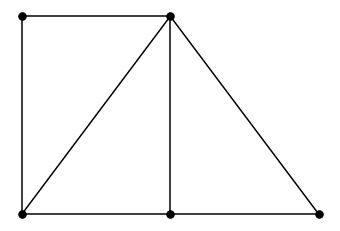

In [36]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
plt.show()

In [37]:
# dirichlet boundary conditions
# [node, DoF (x=1, y=2, theta=3), value]
bc = np.array([
    [1,1,0],
    [1,2,0],
    [3,1,0],
    [5,1,0],
    [5,2,0]
])

In [38]:
# neumann boundary conditions - e.g. forces
# [node, DoF (x=1,y=2), magnitude of force]
forces = np.array([
    [2,1, 10e4],
    [4,2,-10e4]
])

<h3>Finding Elemental Stiffness Matrices</h3>

In [39]:
# initializing the vectors F, u, and the matrix K
F = u = np.zeros(3*len(nodes))
K = np.zeros([3*len(nodes), 3*len(nodes)])

In [40]:
#returns x and y coordinates of an element's nodew
def XY(nodes, elements, i):
    return np.array([
        nodes[int(elements[i,0]-1)],
        nodes[int(elements[i,1]-1)]
    ])

In [41]:
#Sample output for element 2
sp.Matrix(XY(nodes, elements, 1))

Matrix([
[0, 4],
[0, 0]])

In [42]:
# elemental stiffness matrix for truss element in local coordinates
def Kel(XY, E, A):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    
    Kel = E*A/L*np.array([
    [1, 0, -1, 0],
    [0, 0, 0, 0],
    [-1, 0, 1, 0],
    [0, 0, 0, 0]
    ])
    
    return Kel  

In [43]:
#Sample output for element 2
sp.Matrix(Kel(XY(nodes, elements, 1), elements[1, 2], elements[1, 3]))

Matrix([
[ 500000.0, 0.0, -500000.0, 0.0],
[      0.0, 0.0,       0.0, 0.0],
[-500000.0, 0.0,  500000.0, 0.0],
[      0.0, 0.0,       0.0, 0.0]])

In [44]:
# elemental stiffness matrix of a beam element in local coordinates
def Kbel(XY, E, I):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    
    L = sp.sqrt((x2-x1)**2 + (y2-y1)**2)

    Kbel = ((E*I)/(L**3))*np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
                  
    return Kbel  

In [45]:
#Sample output for element 2
sp.Matrix(Kbel(XY(nodes, elements, 1), elements[1, 2], elements[1, 4]))

Matrix([
[ 0.312375,  0.62475, -0.312375,  0.62475],
[  0.62475,    1.666,  -0.62475,    0.833],
[-0.312375, -0.62475,  0.312375, -0.62475],
[  0.62475,    0.833,  -0.62475,    1.666]])

In [46]:
# combined elemental stiffness matrix for frame element in local coordinates
def Kel_f(Kel_t,Kel_b):
    Kel_f = np.array([
        [Kel_t[0, 0], 0, 0, Kel_t[0, 2], 0, 0],
        [0, Kel_b[0, 0], Kel_b[0, 1], 0, Kel_b[0, 2], Kel_b[0, 3]],
        [0, Kel_b[1, 0], Kel_b[1, 1], 0, Kel_b[1, 2], Kel_b[1, 3]],
        [Kel_t[2, 0], 0, 0, Kel_t[2, 2], 0, 0],
        [0, Kel_b[2, 0], Kel_b[2, 1], 0, Kel_b[2, 2], Kel_b[2, 3]],
        [0, Kel_b[3, 0], Kel_b[3, 1], 0, Kel_b[3, 2], Kel_b[3, 3]],
    ])
    
    return Kel_f

In [47]:
#Sample output for element 2
sp.Matrix(Kel_f(Kel(XY(nodes, elements, 1), elements[1, 2], elements[1, 3]),Kbel(XY(nodes, elements, 1), elements[1, 2], elements[1, 4])))

Matrix([
[ 500000.0,         0,        0, -500000.0,         0,        0],
[        0,  0.312375,  0.62475,         0, -0.312375,  0.62475],
[        0,   0.62475,    1.666,         0,  -0.62475,    0.833],
[-500000.0,         0,        0,  500000.0,         0,        0],
[        0, -0.312375, -0.62475,         0,  0.312375, -0.62475],
[        0,   0.62475,    0.833,         0,  -0.62475,    1.666]])

In [48]:
# elemental stiffness matrix for frame element in global coordinates
def Kel_f_global(Kel_f, XY):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    c = (x2-x1)/L
    s = (y2-y1)/L
    
    T_e = np.array([
        [c, s, 0, 0, 0, 0],
        [-s, c, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, c, s, 0],
        [0, 0, 0, -s, c, 0],
        [0, 0, 0, 0, 0, 1]
    ])
    
    T_e_T = np.transpose(T_e)
    
    Kel_f_global = np.matmul(np.matmul(T_e, Kel_f), T_e_T)
    
    return Kel_f_global

In [49]:
#Sample output for element 2
sp.Matrix(Kel_f_global(Kel_f(Kel(XY(nodes, elements, 1), elements[1, 2], elements[1, 3]),Kbel(XY(nodes, elements, 1), elements[1, 2], elements[1, 4])),XY(nodes, elements, 1)))

Matrix([
[ 0.312375,         0, -0.62475, -0.312375,         0, -0.62475],
[        0,  500000.0,        0,         0, -500000.0,        0],
[ -0.62475,         0,    1.666,   0.62475,         0,    0.833],
[-0.312375,         0,  0.62475,  0.312375,         0,  0.62475],
[        0, -500000.0,        0,         0,  500000.0,        0],
[ -0.62475,         0,    0.833,   0.62475,         0,    1.666]])

In [50]:
# for element e, what degrees of freedom in the structure do the nodes correspond to?
def elementDoF(node_DoF, elements, i):
    node_i = int(elements[i,:2][0])-1 # -1 is for python counting
    node_j = int(elements[i,:2][1])-1 # -1 is for python counting
    
    elementDoF = np.array([
        [node_DoF[3*node_i]],
        [node_DoF[3*node_i+1]],
        [node_DoF[3*node_i+2]],
        [node_DoF[3*node_j]],
        [node_DoF[3*node_j+1]],
        [node_DoF[3*node_j+2]],
    ])

    return elementDoF

In [51]:
#Sample output for element 2
sp.Matrix(elementDoF(node_DoF, elements, 1))

Matrix([
[0],
[1],
[2],
[6],
[7],
[8]])

In [52]:
# augment the elemental stiffness matrix by inserting the local stiffness matrix 
# into the correct location within the global stiffness matrix.
# this could be done more efficiently, but i will add a visualization above to help identify what goes where

def Kaug(K, e, Kel, node_DoF):
    i = elementDoF(node_DoF, elements, e)[0][0] #Xi
    j = elementDoF(node_DoF, elements, e)[1][0] #Yi
    m = elementDoF(node_DoF, elements, e)[2][0] #Thetai
    k = elementDoF(node_DoF, elements, e)[3][0] #Xj
    l = elementDoF(node_DoF, elements, e)[4][0] #Yj
    n = elementDoF(node_DoF, elements, e)[5][0] #Thetaj
    
    #Diagonal Values
    K[i][i] += Kel[0][0] 
    K[j][j] += Kel[1][1]
    K[m][m] += Kel[2][2]
    K[k][k] += Kel[3][3]
    K[l][l] += Kel[4][4]
    K[n][n] += Kel[5][5]
    
    #Xi Values
    K[i][j] += Kel[0][1]
    K[j][i] += Kel[0][1]
    K[i][m] += Kel[0][2]
    K[m][i] += Kel[0][2]
    K[i][k] += Kel[0][3]
    K[k][i] += Kel[0][3] 
    K[i][l] += Kel[0][4]
    K[l][i] += Kel[0][4]
    K[i][n] += Kel[0][5]
    K[n][i] += Kel[0][5]
    
    #Yi Values  
    K[j][m] += Kel[1][2]
    K[m][j] += Kel[1][2] 
    K[j][k] += Kel[1][3]
    K[k][j] += Kel[1][3]    
    K[j][l] += Kel[1][4]
    K[l][j] += Kel[1][4]
    K[j][n] += Kel[1][5]
    K[n][j] += Kel[1][5]
    
    #Thetai Values
    K[m][k] += Kel[2][3]
    K[k][m] += Kel[2][3]
    K[m][l] += Kel[2][4]
    K[l][m] += Kel[2][4]
    K[m][n] += Kel[2][5]
    K[n][m] += Kel[2][5]
    
    #Xj Values
    K[k][l] += Kel[3][4]
    K[l][k] += Kel[3][4]
    K[k][n] += Kel[3][5]
    K[n][k] += Kel[3][5]
    
    #Yj Values
    K[l][n] += Kel[4][5]
    K[n][l] += Kel[4][5]
    
    return K

In [53]:
#Sample output for element 2
sp.Matrix(Kaug(K, 1, Kel_f_global(Kel_f(Kel(XY(nodes, elements, 1), elements[1, 2], elements[1, 3]),Kbel(XY(nodes, elements, 1), elements[1, 2], elements[1, 4])),XY(nodes, elements, 1)), node_DoF))

Matrix([
[ 0.312375,       0.0, -0.62475, 0.0, 0.0, 0.0, -0.312375,       0.0, -0.62475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[      0.0,  500000.0,      0.0, 0.0, 0.0, 0.0,       0.0, -500000.0,      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[ -0.62475,       0.0,    1.666, 0.0, 0.0, 0.0,   0.62475,       0.0,    0.833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[      0.0,       0.0,      0.0, 0.0, 0.0, 0.0,       0.0,       0.0,      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[      0.0,       0.0,      0.0, 0.0, 0.0, 0.0,       0.0,       0.0,      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[      0.0,       0.0,      0.0, 0.0, 0.0, 0.0,       0.0,       0.0,      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[-0.312375,       0.0,  0.62475, 0.0, 0.0, 0.0,  0.312375,       0.0,  0.62475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[      0.0, -500000.0,      0.0, 0.0, 0.0, 0.0,       0.0,  500000.0,      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[ -0.62475,       0.0,    0.833, 0.0, 0.0, 0.0,   0.62475,       0.0,    1.666, 0.0, 0.0, 0.0, 0.0, 0.0

<h3>Calculating Master Stiffness Matrix</h3>

In [54]:
def MasterStiffness(nodes, node_DoF, elements, K):
# Calculate the Master Stiffness matrix:
# 1. Get the x & y coordinates of each node connected to element i
# 2. Calculate the truss member stiffness matrix for element i
# 3. Calculate the beam member stiffness matrix for element i
# 4. Combine to form frame member stiffness matrix for element i in local coordinates
# 5. Calculate member stiffness matrix in global coordinates
# 6. Augment the elemental stiffness matrix to the size of K
# 7. Add it to K, loop over the remaining elements
    for i in range(len(elements)):
        nodesXY = XY(nodes, elements, i) #1
        Keli  = Kel(nodesXY, elements[i,2], elements[i,3]) #2
        Kbeli  = Kbel(nodesXY, elements[i,2], elements[i,4]) #3
        Kel_fi = Kel_f(Keli, Kbeli) #4
        Kel_f_globali = Kel_f_global(Kel_fi, nodesXY) #5
        K = Kaug(K, i, Kel_f_globali, node_DoF) #6 and 7  
    return K

In [55]:
#Reset K to clear the example results and then calculate master stiffness matrix
K = np.zeros([3*len(nodes), 3*len(nodes)])
K = MasterStiffness(nodes, node_DoF, elements,K)

In [56]:
sp.Matrix(K)

Matrix([
[ 666666.979041667,                0.0,          -0.62475, -666666.666666667,                0.0,               0.0,         -0.312375,                0.0,          -0.62475,               0.0,                0.0,               0.0,               0.0,                0.0,               0.0],
[              0.0,   500000.740444445,  1.11066666666667,               0.0, -0.740444444444444,  1.11066666666667,               0.0,          -500000.0,               0.0,               0.0,                0.0,               0.0,               0.0,                0.0,               0.0],
[         -0.62475,   1.11066666666667,  3.88733333333333,               0.0,  -1.11066666666667,  1.11066666666667,           0.62475,                0.0,             0.833,               0.0,                0.0,               0.0,               0.0,                0.0,               0.0],
[-666666.666666667,                0.0,               0.0,  954667.183759747,                0.0,         -1.264494

<h3>Reduce K by Eliminating Constrained Degrees of Freedom</h3>

In [57]:
# initialize vectors for the specified displacements and forces. these will be [1 x DoF]
u_specified=[]
F_specified=[0]*3*len(nodes)

# what DoF are specified?
for i in range(len(bc)):
    u_specified.append(3*(bc[i,0]-1)+bc[i,1]-1)
# assign the external forces to the corresponding DoF in F   
for i in range(len(forces)):    
    F_specified[int(3*(forces[i,0]-1)+forces[i,1]-1)]=forces[i,2]
    
u_unknown = np.delete(u,u_specified) # deleting the specified displacments from u
K_reduced = np.delete(K,u_specified,0) # deleting rows
K_reduced = np.delete(K_reduced,u_specified,1) # deleting columns
F_specified = np.delete(F_specified,u_specified) # deleting the forces that correspond to specified displacments

In [58]:
sp.Matrix(K_reduced)

Matrix([
[ 3.88733333333333,              0.0, -1.11066666666667,  1.11066666666667,                0.0,             0.833,              0.0,                0.0,              0.0,              0.0],
[              0.0, 954667.183759747,               0.0,         -1.264494,    191999.92323072,         -0.319872,        -0.312375,                0.0,         -0.62475,        -0.319872],
[-1.11066666666667,              0.0,  1012000.85559836, -1.11066666666667,   -256000.05757696,         -0.239904,              0.0,          -500000.0,              0.0,         0.239904],
[ 1.11066666666667,        -1.264494, -1.11066666666667,  6.55293333333333,           0.239904,            0.6664,          0.62475,                0.0,            0.833,           0.6664],
[              0.0,  191999.92323072,  -256000.05757696,          0.239904,   756000.798021405,  1.35057066666667,              0.0, -0.740444444444444, 1.11066666666667,              0.0],
[            0.833,        -0.319872,    

<h3>Solve for Unknown Displacements</h3>

In [59]:
u_unknown = sp.Matrix(K_reduced).inv()*sp.Matrix(F_specified)

In [60]:
u_unknown

Matrix([
[-0.0542595988100242],
[  0.128672918136279],
[ -0.254790354084613],
[-0.0178607241149615],
[ -0.118957286411099],
[-0.0626947121794225],
[3.00983184569914e-8],
[ -0.454789697124934],
[ 0.0179617279117152],
[  0.168636537683663]])

In [61]:
# create a list of all the displacement degrees of freedom (DoF)
u_DoF=[]
for i in range(len(u)):
    u_DoF.append(i)

# get the index locations of the free degrees of freedom (DoF)    
u_free = (list(set(u_DoF) - set(u_specified)))    

# put the free (formerly unknown) displacements into the displacement vector u
# np.put(u,u_free,u_unknown)
for i in u_specified:
    u_unknown = u_unknown.row_insert(int(i), sp.Matrix([0]))
    
u = u_unknown    

In [62]:
#Total Displacement Vector
u

Matrix([
[                  0],
[                  0],
[-0.0542595988100242],
[  0.128672918136279],
[ -0.254790354084613],
[-0.0178607241149615],
[                  0],
[ -0.118957286411099],
[-0.0626947121794225],
[3.00983184569914e-8],
[ -0.454789697124934],
[ 0.0179617279117152],
[                  0],
[                  0],
[  0.168636537683663]])

<h3>Solve for Forces/Moments</h3>

In [63]:
#Solve for forces
F = np.dot(np.array(K),np.array(u))

In [64]:
#Display result for forces/moments
#Note: Many quantities are very close to zero such that they can be approximated as such (Moments)
sp.Matrix(F)

Matrix([
[    -85781.8723569802],
[     59478.7517620132],
[-2.28983498828939e-16],
[             100000.0],
[-1.19881798932298e-10],
[-6.38378239159465e-16],
[    -44608.9708481483],
[ 1.85687819287406e-11],
[-1.42247325030098e-16],
[-2.84743409406651e-12],
[            -100000.0],
[  7.7715611723761e-16],
[     30390.8432051285],
[     40521.2482379868],
[ 3.33066907387547e-16]])

<h2>Plotting the initial and deformed truss</h2>
First, let's collect the new location of the nodes.

In [65]:
#Trim rotational displacements from u vector as they dont factor into x,y location of the nodes
u_rot = [2, 5, 8, 11, 14]
u_frame = np.delete(u, u_rot, None)
nodes_new = nodes+np.reshape(u_frame,(len(nodes),2))

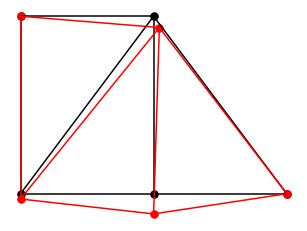

In [66]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
plt.plot(nodes_new[:,0], nodes_new[:,1], 'r.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
# plot the deformed elements
for i in range(len(elements)):
    plt.plot(np.array([
    nodes_new[int(elements[i,0]-1),0], nodes_new[int(elements[i,1]-1),0]]),
         np.array([nodes_new[int(elements[i,0]-1),1], nodes_new[int(elements[i,1]-1),1]]),
         'r-')    
plt.show()

<h2>Compare Forces and Displacements to Truss Element Method</h2>

In [67]:
#Results from planar truss code
u_truss = np.array([0, 0, 0.0945497630331754, -0.220667950236967, 0, -0.0507109004739336, 0, -0.420667950236967, 0, 0])
F_truss = np.array([-63033.1753554503, 25355.4502369668, 100000, -1.4915713109076e-10, 19016.5876777252, 9.45874489843845e-11, 0, -100000, -55983.4123222749, 74644.5497630333])

In [68]:
sp.Matrix(u_truss)

Matrix([
[                0.0],
[                0.0],
[ 0.0945497630331754],
[ -0.220667950236967],
[                0.0],
[-0.0507109004739336],
[                0.0],
[ -0.420667950236967],
[                0.0],
[                0.0]])

In [69]:
sp.Matrix(F_truss)

Matrix([
[   -63033.1753554503],
[    25355.4502369668],
[            100000.0],
[-1.4915713109076e-10],
[    19016.5876777252],
[9.45874489843845e-11],
[                 0.0],
[           -100000.0],
[   -55983.4123222749],
[    74644.5497630333]])

In [70]:
#Results from frame code with rotational displacements and moments removed
sp.Matrix(u_frame)

Matrix([
[                  0],
[                  0],
[  0.128672918136279],
[ -0.254790354084613],
[                  0],
[ -0.118957286411099],
[3.00983184569914e-8],
[ -0.454789697124934],
[                  0],
[                  0]])

In [71]:
#Trim moments from F vector
F_rot = [2, 5, 8, 11, 14]
F_frame = np.delete(F, F_rot, None)
sp.Matrix(F_frame)

Matrix([
[    -85781.8723569802],
[     59478.7517620132],
[             100000.0],
[-1.19881798932298e-10],
[    -44608.9708481483],
[ 1.85687819287406e-11],
[-2.84743409406651e-12],
[            -100000.0],
[     30390.8432051285],
[     40521.2482379868]])

<h3>Difference in Displacements</h3>

In [72]:
#Calculate difference between frame and planar truss results
u_diff = u_frame - u_truss

In [73]:
sp.Matrix(u_diff)

Matrix([
[                  0],
[                  0],
[ 0.0341231551031036],
[-0.0341224038476458],
[                  0],
[-0.0682463859371658],
[3.00983184569914e-8],
[-0.0341217468879672],
[                  0],
[                  0]])

<h3>Difference in Forces</h3>

In [74]:
#Calculate difference between frame and planar truss results
F_diff = F_frame - F_truss

In [75]:
sp.Matrix(F_diff)

Matrix([
[    -22748.6970015299],
[     34123.3015250464],
[-4.36557456851006e-11],
[ 2.92753321584624e-11],
[    -63625.5585258735],
[-7.60186670556439e-11],
[-2.84743409406651e-12],
[ 4.36557456851006e-11],
[     86374.2555274034],
[    -34123.3015250465]])

<h3>Plot Initial and Deformed Results from Frame and Truss Methods</h3>
<h4>Frame Method: Red</h4>
<h4>Truss Method: Blue</h4>

In [76]:
#Find new node locations for truss method
nodes_new_truss = nodes+np.reshape(u_truss,(len(nodes),2))

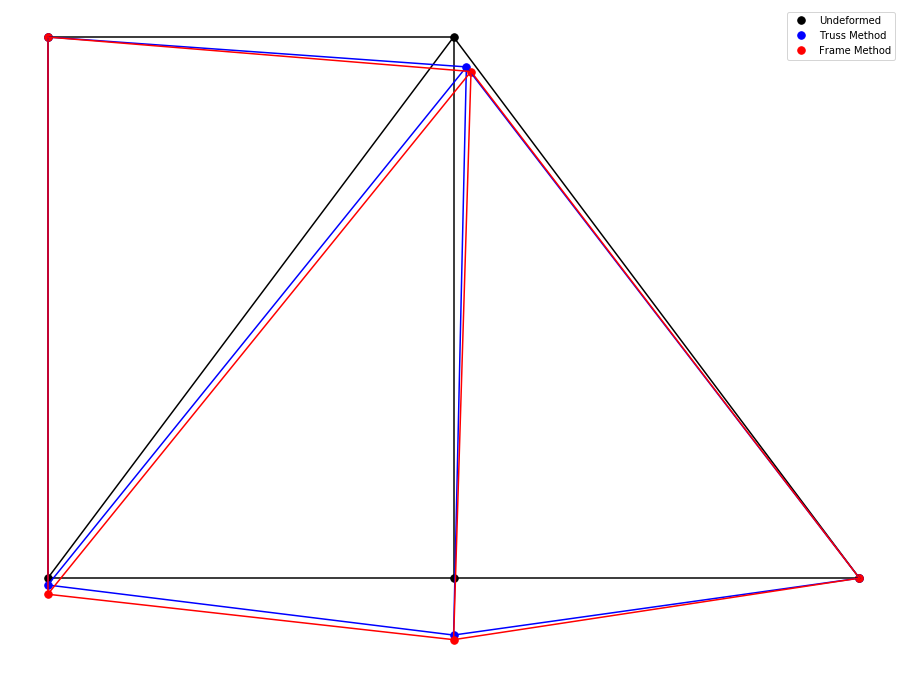

In [77]:
# set axes aspect ratio = 1
# turn off the axis
plt.figure(figsize=(16, 16))
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
plt.plot(nodes_new_truss[:,0], nodes_new_truss[:,1], 'b.',markersize=15)
plt.plot(nodes_new[:,0], nodes_new[:,1], 'r.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
# plot the deformed elements using truss method in blue
for i in range(len(elements)):
    plt.plot(np.array([
    nodes_new_truss[int(elements[i,0]-1),0], nodes_new_truss[int(elements[i,1]-1),0]]),
         np.array([nodes_new_truss[int(elements[i,0]-1),1], nodes_new_truss[int(elements[i,1]-1),1]]),
         'b-')
# plot the deformed elements using Frame method in Red
for i in range(len(elements)):
    plt.plot(np.array([
    nodes_new[int(elements[i,0]-1),0], nodes_new[int(elements[i,1]-1),0]]),
         np.array([nodes_new[int(elements[i,0]-1),1], nodes_new[int(elements[i,1]-1),1]]),
         'r-')    
plt.legend(['Undeformed', 'Truss Method', 'Frame Method'])
plt.show()